In [ ]:
pip install tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#0. Initial Setting

In [ ]:
import numpy as np
from scipy.special import logsumexp
from scipy.special import softmax
import warnings
warnings.filterwarnings("ignore")

theta1 = np.array([4.57,2.5])#np.array([[[4.57,3.41],[3.86,3.18]],[[2.69,2.75],[3.58,4.57]]]) #s,a1,a2

theta23 = np.array([0.9,0.5,0.9,0.2])



TimePeriod= 150
SamplePath = 300
num_discrete = 100

z_old = np.arange(2,dtype=int) #observation
a1_old = np.arange(2,dtype = int)
a2_old = np.arange(2,dtype = int)
x_old = np.linspace(0,1,num_discrete) #belief

#1. Generate Dynamic Part and Policy Part

In [ ]:
def Dynamic(theta23):
  
  trans = np.ones([2,2,2,2])      #s_t,a1,a2,s_{t+1}
  trans[0,:,:,0] = trans[1,:,:,1] = 1-theta23[1]
  trans[0,:,:,1] = trans[1,:,:,0] = theta23[1]

  trans[0,0,0,0] = trans[1,1,1,1] = theta23[0]
  trans[0,0,0,1] = trans[1,1,1,0] = 1-theta23[0]



  observe = np.ones([2,2,2,2]) #a1,a2,s_{t+1},z_{t+1}
  observe[:,:,0,0] = observe[:,:,1,1] = 1-theta23[3]
  observe[:,:,0,1] = observe[:,:,1,0] = theta23[3]
  observe[0,0,0,0] = observe[1,1,1,1] = theta23[2]
  observe[0,0,0,1] = observe[1,1,1,0] = 1-theta23[2]
  return trans,observe
#print(observe)

def Reward(theta1):
  rw = np.ones([2,2,2])#s,a1,a2
  rw = theta1[1]*rw
  rw[0,0,0] = rw[1,1,1] = theta1[0]
  return rw

def SigmaLambda(z_old,x_old,a1_old,a2_old,theta23= theta23,num_discrete=num_discrete,T = None): #xt,a1_t,a2_t,z_{t+1}
  trans,observe = Dynamic(theta23)  #s_t,a1,a2,s_{t+1} #a1,a2,s_{t+1},z_{t+1}
  if T==None: #generate function for Q function iteration
      x_new = np.zeros([num_discrete,2,2,2])
      sigma = np.zeros([num_discrete,2,2,2])
      x_old = np.vstack([x_old,1-x_old]).T

      for a1 in a1_old:#range(2):
        for a2 in a2_old:#range(2):
          for z_new in z_old:#range(2):
            x_new_tep = x_old.dot(trans[:,a1,a2,0]*observe[a1,a2,0,z_new])
            sigma[:,a1,a2,z_new] = x_new_tep + x_old.dot(trans[:,a1,a2,1]*observe[a1,a2,1,z_new])
            x_new[:,a1,a2,z_new] = x_new_tep/sigma[:,a1,a2,z_new]
      belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
      belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
      iterpolate = np.zeros(belief_f.shape)
      iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]
  elif T==1: #generate 1 period data for data generation
      x_new = np.zeros(x_old.shape)
      sigma = np.zeros(x_old.shape)
      #x_old = np.vstack([x_old,1-x_old]).T

      x_new_tep = (x_old *trans[0,a1_old,a2_old,0] + (1-x_old)*trans[1,a1_old,a2_old,0] )* observe[a1_old,a2_old,0,z_old]
      sigma = x_new_tep + (x_old *trans[0,a1_old,a2_old,1] + (1-x_old)*trans[1,a1_old,a2_old,1] )* observe[a1_old,a2_old,1,z_old]
      x_new = x_new_tep/sigma

      belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
      belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
      iterpolate = np.zeros(belief_f.shape)
      iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]
  else:      #generate whole belief for recover process
      x_new = np.zeros(a1_old.shape) # T, N
      sigma = np.zeros(z_old.shape) # T-1 ,N
      x_new[0,:] = x_old
      #x_old = np.vstack([x_old,1-x_old]).T
      for t in range(1,T):
        a1 = a1_old[t-1,:]
        a2 = a2_old[t-1,:]
        z = z_old[t-1,:]
        x_new_tep = (x_new[t-1,:] *trans[0,a1,a2,0] + (1-x_new[t-1,:])*trans[1,a1,a2,0] )* observe[a1,a2,0,z]
        sigma[t-1,:] = x_new_tep + (x_new[t-1,:] *trans[0,a1,a2,1] + (1-x_new[t-1,:])*trans[1,a1,a2,1] )* observe[a1,a2,1,z]
        x_new[t,:] = x_new_tep/sigma[t-1,:]

      belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
      belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
      iterpolate = np.zeros(belief_f.shape)
      iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]      

  return sigma,x_new,[iterpolate,np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))]
#print(SigmaLambda()[0][:,0,0,0])



def ValueIteration(theta1,sigma,xiterpolate, num_discrete=num_discrete,beta = 0.9,
                   gamma = 0.5772,thread_inner = 1e-7,thread_outer = 1e-7): #xt, a1 or xt,a2
  rw = Reward(theta1)
  iterpolate,belief_f,belief_c = xiterpolate[0],xiterpolate[1],xiterpolate[2]
  x_old = np.linspace(0,1,num=num_discrete)
  #x_old = np.vstack([x_old,1-x_old]).T

  pi1_new = 0.5*np.ones([num_discrete,2]) #xt,a1
  # Q1_new = np.zeros([num_discrete,2]) #xt,a2
  # Q2_new = np.zeros([num_discrete,2])

  pi2_old = pi1_new.copy()
  count = 0
  #pi1_old = np.zeros([2,2])
  for ol in range(1000):
    pi1_old = pi1_new.copy()
    
    Q1_new = np.zeros([num_discrete,2]) #xt,a2
    Q2_new = np.zeros([num_discrete,2])

    for il in range(1000):
      Q2_old = Q2_new.copy()
      for a2 in range(2):
        #a1 = 0
        it0,bf0,bc0 = iterpolate[:,0,a2,:],belief_f[:,0,a2,:],belief_c[:,0,a2,:]
        V2_a10 =  np.stack([it0*Q2_old[bf0,0] + (1-it0)*Q2_old[bc0,0],
                            it0*Q2_old[bf0,1] + (1-it0)*Q2_old[bc0,1]],axis=2)
        Q2_tepa10 = x_old * rw[0,0,a2] + (1-x_old) * rw[1,0,a2] + beta * np.sum(sigma[:,0,a2,:]*(gamma+logsumexp(V2_a10,axis=2)),axis=1)

        #a1=1
        it1,bf1,bc1 = iterpolate[:,1,a2,:],belief_f[:,1,a2,:],belief_c[:,1,a2,:]
        V2_a11 =  np.stack([it1*Q2_old[bf1,0] + (1-it1)*Q2_old[bc1,0],
                            it1*Q2_old[bf1,1] + (1-it1)*Q2_old[bc1,1]],axis=2)
        Q2_tepa11 = x_old * rw[0,1,a2] + (1-x_old) * rw[1,1,a2] + beta * np.sum(sigma[:,1,a2,:]*(gamma+logsumexp(V2_a11,axis=2)),axis=1)
          
        Q2_new[:,a2] = pi1_old[:,0] *Q2_tepa10 + pi1_old[:,1] * Q2_tepa11
        #print(it0)
      #print(il,np.max(np.abs((Q2_new-Q2_old)/Q2_old)))
      if np.max(np.abs((Q2_new-Q2_old)/Q2_old)) <thread_inner: 
        #print('Q2',il,np.max(np.abs((Q2_new-Q2_old)/Q2_old)))
        break

    pi2_new = softmax(Q2_new,axis=1)
    if np.max(np.abs((pi2_old-pi2_new)/pi2_old)) <thread_outer:
      count = np.max(np.abs((pi2_old-pi2_new)/pi2_old))


    pi2_old = pi2_new.copy()
    for il in range(1000):
      Q1_old = Q1_new.copy()
      for a1 in range(2):
        #a2 = 0
        it0,bf0,bc0 = iterpolate[:,a1,0,:],belief_f[:,a1,0,:],belief_c[:,a1,0,:]
        V1_a20 =  np.stack([it0*Q1_old[bf0,0] + (1-it0)*Q1_old[bc0,0],
                            it0*Q1_old[bf0,1] + (1-it0)*Q1_old[bc0,1]],axis=2)
        Q1_tepa20 = x_old * rw[0,a1,0] + (1-x_old) * rw[1,a1,0] + beta * np.sum(sigma[:,a1,0,:]*(gamma+logsumexp(V1_a20,axis=2)),axis=1)

        #a2=1
        it1,bf1,bc1 = iterpolate[:,a1,1,:],belief_f[:,a1,1,:],belief_c[:,a1,1,:]
        V1_a21 =  np.stack([it1*Q1_old[bf1,0] + (1-it1)*Q1_old[bc1,0],
                            it1*Q1_old[bf1,1] + (1-it1)*Q1_old[bc1,1]],axis=2)
        Q1_tepa21 = x_old * rw[0,a1,1] + (1-x_old) * rw[1,a1,1] + beta * np.sum(sigma[:,a1,1,:]*(gamma+logsumexp(V1_a21,axis=2)),axis=1)
          
        Q1_new[:,a1] = pi2_old[:,0] *Q1_tepa20 + pi2_old[:,1] * Q1_tepa21
      if np.max(np.abs((Q1_new-Q1_old)/Q1_old)) <thread_inner:
        #print('Q1',il,np.max(np.abs((Q1_new-Q1_old)/Q1_old)))
        break

    pi1_new = softmax(Q1_new,axis=1)
    
    #print('pi1 pi2',ol,np.max(np.abs((pi1_old-pi1_new)/pi1_old)),count)

    if np.max(np.abs((pi1_old-pi1_new)/pi1_old)) <thread_outer and count:
      #print(ol,np.max(np.abs((pi1_old-pi1_new)/pi1_new)))
      break
  return Q1_new,Q2_new,pi1_new,pi2_new

# sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=theta23,num_discrete=num_discrete)
# Q1,Q2,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate)

Check Q value function works (doesn't depend on discrete intervals) 

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


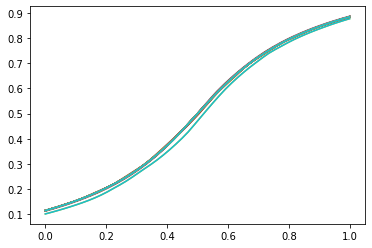

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
discrete_tol = 10*(1+np.arange(20))
Q1_plot = []
Q2_plot = []
pi1_plot = []
pi2_plot = []
for num_disc in tqdm(discrete_tol):
  x_old_test = np.linspace(0,1,num_disc)
  sigma,_,xiterpolate= SigmaLambda(z_old,x_old_test,a1_old,a2_old,theta23=theta23,num_discrete=num_disc)

  Q1,Q2,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate, num_discrete=num_disc)
  Q1_plot.append(Q1)
  Q2_plot.append(Q2)
  pi1_plot.append(pi1)
  pi2_plot.append(pi2)

for i in range(len(discrete_tol)):
  plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,0],np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,0])

#2. Data Generation Process

In [ ]:
##################################Global Parameter#################################
# theta1 = np.array([4.57,2.5])#np.array([[[4.57,3.41],[3.86,3.18]],[[2.69,2.75],[3.58,4.57]]]) #s,a1,a2
# theta23 = np.array([0.9,0.5,0.9,0.2])
# TimePeriod= 150
# SamplePath = 300
# num_discrete = 100
# z_old = np.arange(2,dtype=int) #observation
# a1_old = np.arange(2,dtype = int)
# a2_old = np.arange(2,dtype = int)
# x_old = np.linspace(0,1,num_discrete) #belief
###################################################################################

def DataGeneration(theta1 = theta1,theta23=theta23,T=TimePeriod,N=SamplePath,num_discrete=num_discrete):
  HdState = np.zeros([T,N],dtype= int)    #hidden state
  ObState = np.zeros([T-1,N],dtype = int) #observation state
  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action

  HdState[0,:] = np.random.randint(0,2,size=N)
  belief[0,:] = np.random.uniform(size=N)
      

  trans,observe = Dynamic(theta23)
  sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=theta23,num_discrete=num_discrete)
  _,_,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate)
  for t in tqdm(range(T)):
    # iterpolate belief
    belief_f = np.floor(belief[t,:] *(num_discrete-1))/(num_discrete-1)
    belief_c = np.ceil(belief[t,:] *(num_discrete-1))/(num_discrete-1)
    iterpolate = np.zeros(belief_f.shape)
    iterpolate[np.where((belief_f-belief_c)!=0)] = (belief[t,:] -belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]
    belief_fint,belief_cint = np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))

    # generate new action for both agents
    action_mat1 = np.random.random(size=N)
    p1 = iterpolate*pi1[belief_fint,0] + (1-iterpolate)*pi1[belief_cint,0]
    action1[t,:] = np.int_(p1<=action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p2 = iterpolate*pi2[belief_fint,0] + (1-iterpolate)*pi2[belief_cint,0]
    action2[t,:] = np.int_(p2<=action_mat2)
    
    if t!=T-1:
      # generate new hidden state and observation state
      state_mat1 = np.random.random(size=N)
      HdState[t+1,:] = np.int_(trans[HdState[t,:],action1[t,:],action2[t,:],0]<=state_mat1)
      state_mat2 = np.random.random(size=N)
      ObState[t,:] = np.int_(observe[action1[t,:],action2[t,:],HdState[t+1,:],0]<=state_mat2)

      # update new belief
      _,belief[t+1,:],_ = SigmaLambda(ObState[t,:] ,belief[t,:],action1[t,:],action2[t,:],theta23=theta23,num_discrete=num_discrete,T=1)
  return ObState, action1,action2,belief,HdState


ObState, action1,action2,belief,HdState= DataGeneration()
#haha = SigmaLambda()

100%|██████████| 150/150 [00:00<00:00, 3926.64it/s]


#3.1 Recover Dynamic Part

In [ ]:
theta23

array([0.9, 0.5, 0.9, 0.2])

In [ ]:
from scipy.optimize import minimize
ini_x0 = 0.8*theta23
print('start from:',ini_x0 )

def func1(theta23,ObState=ObState, action1=action1,action2 = action2,x0=belief[0,:],T=TimePeriod):
  sigma,_,_ = SigmaLambda(ObState,x0,action1,action2,theta23= theta23,num_discrete=num_discrete,T = TimePeriod)
  res = -np.sum(np.log(sigma))
  #print(theta23,res)
  return res

res1 = minimize(func1,ini_x0, bounds=[[0.00001,0.99999],[0.00001,0.99999],[0.00001,0.99999],[0.00001,0.99999]])
#trans_est = np.vstack([res1.x,1-res1.x]).T.reshape([2,2,2,2])
print(res1)

start from: [0.72 0.4  0.72 0.16]
      fun: 25166.040249791076
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.37471182, -0.44310582,  0.0007276 ,  0.1549779 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 125
      nit: 14
   status: 0
  success: True
        x: array([0.92281832, 0.49713157, 0.88363276, 0.1692688 ])


#3.2 Recover Reward Part

In [ ]:
theta1.reshape(-1)

array([4.57, 2.5 ])

In [ ]:
ini_x0 = 0.8*theta1[0].reshape(-1)
print('start from:',ini_x0 )
sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=res1.x,num_discrete=num_discrete)
_,_,beliefIP = SigmaLambda(ObState,belief[0,:],action1,action2,theta23= res1.x,num_discrete=num_discrete,T = TimePeriod)

def func2(theta11,theta12=theta1[1],sigma = sigma,xiterpolate=xiterpolate,beliefIP=beliefIP,action1 = action1,action2 = action2,T=TimePeriod):
  #theta1 = theta1.reshape([2,2,2])
  _,_,pi1,pi2 = ValueIteration(np.array([theta11,theta12]),sigma,xiterpolate)
  p1 = beliefIP[0] *pi1[beliefIP[1],action1] + (1-beliefIP[0]) *pi1[beliefIP[2],action1]
  p2 = beliefIP[0] *pi2[beliefIP[1],action2] + (1-beliefIP[0]) *pi2[beliefIP[2],action2]
  res = - np.sum(np.log(p1)) -np.sum(np.log(p2))
  print(theta11,res)
  return res

res2 = minimize(func2,ini_x0,bounds = [(1e-6,100)])#,(1e-6,100)])#method='Nelder-Mead')
print(res2)

start from: [3.656]
[3.656] 47727.26579889319
[3.65600001] 47727.2656752112
[100.] 1485568.0867081978
[100.00000001] 1485568.0868603454
[15.7649841] 202380.00377698167
[15.76498411] 202380.00392959267
[5.40185751] 46439.05196718471
[5.40185752] 46439.05206625809
[4.62536441] 41679.46565484992
[4.62536442] 41679.46566944063
[4.49125896] 41621.47357471683
[4.49125897] 41621.473568432106
[4.53163253] 41609.27812514194
[4.53163254] 41609.27812535623
[4.5303013] 41609.263671185116
[4.53030131] 41609.2636711879
[4.53028376] 41609.26366867876
[4.53028377] 41609.263668678715
      fun: 41609.26366867876
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00436557])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 6
   status: 0
  success: True
        x: array([4.53028376])


In [ ]:
ini_x0 = 0.8*theta1[0].reshape(-1)
print('start from:',ini_x0 )
sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=theta23,num_discrete=num_discrete)
_,_,beliefIP = SigmaLambda(ObState,belief[0,:],action1,action2,theta23= theta23,num_discrete=num_discrete,T = TimePeriod)

def func2(theta11,theta12= theta1[1],sigma = sigma,xiterpolate=xiterpolate,beliefIP=beliefIP,action1 = action1,action2 = action2,T=TimePeriod):
  #theta1 = theta1.reshape([2,2,2])
  _,_,pi1,pi2 = ValueIteration(np.array([theta11,theta12]),sigma,xiterpolate)
  p1 = beliefIP[0] *pi1[beliefIP[1],action1] + (1-beliefIP[0]) *pi1[beliefIP[2],action1]
  p2 = beliefIP[0] *pi2[beliefIP[1],action2] + (1-beliefIP[0]) *pi2[beliefIP[2],action2]
  res = - np.sum(np.log(p1)) -np.sum(np.log(p2))
  print(theta11,res)
  return res

res2 = minimize(func2,ini_x0,bounds = [(1e-6,100)])#,(1e-6,100)])#method='Nelder-Mead')
print(res2)

start from: [3.656]
[3.656] 47947.38297225551
[3.65600001] 47947.3828461985
[100.] 1315349.3610953803
[100.00000001] 1315349.3612298295
[16.85806243] 196423.92858379256
[16.85806244] 196423.9287185614
[5.71484956] 48098.13121749001
[5.71484957] 48098.131316140294
[4.61355135] 41324.2594754203
[4.61355136] 41324.259481643145
[4.56850525] 41311.35275537275
[4.56850526] 41311.35275483181
[4.57210784] 41311.25729414144
[4.57210785] 41311.25729415212
[4.57203809] 41311.257256941935
[4.5720381] 41311.25725694197
      fun: 41311.257256941935
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00363798])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 4
   status: 0
  success: True
        x: array([4.57203809])


#4. Run Several Times

In [ ]:
ObState_tol=[]
action1_tol=[]
action2_tol=[]
belief_tol=[]
HdState_tol = []
res1_tol = []
res2_tol = []
for i in range(10):
    print('\n\n Data {}:\n\n'.format(i))


    print('Generate Data --->')
    def DataGeneration(theta1 = theta1,theta23=theta23,T=TimePeriod,N=SamplePath,num_discrete=num_discrete):
      HdState = np.zeros([T,N],dtype= int)    #hidden state
      ObState = np.zeros([T-1,N],dtype = int) #observation state
      belief = np.zeros([T,N])                #belief x
      action1 = np.zeros([T,N],dtype = int)   #agent1's action
      action2 = np.zeros([T,N],dtype = int)   #agent2's action

      HdState[0,:] = np.random.randint(0,2,size=N)
      belief[0,:] = np.random.uniform(size=N)

      trans,observe = Dynamic(theta23)
      sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=theta23,num_discrete=num_discrete)
      _,_,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate)
      for t in tqdm(range(T)):
        # iterpolate belief
        belief_f = np.floor(belief[t,:] *(num_discrete-1))/(num_discrete-1)
        belief_c = np.ceil(belief[t,:] *(num_discrete-1))/(num_discrete-1)
        iterpolate = np.zeros(belief_f.shape)
        iterpolate[np.where((belief_f-belief_c)!=0)] = (belief[t,:] -belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]
        belief_fint,belief_cint = np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))
        # generate new action for both agents
        action_mat1 = np.random.random(size=N)
        p1 = iterpolate*pi1[belief_fint,0] + (1-iterpolate)*pi1[belief_cint,0]
        action1[t,:] = np.int_(p1<=action_mat1)

        action_mat2 = np.random.random(size=N)
        p2 = iterpolate*pi2[belief_fint,0] + (1-iterpolate)*pi2[belief_cint,0]
        action2[t,:] = np.int_(p2<=action_mat2)
    
        if t!=T-1:
          # generate new hidden state and observation state
          state_mat1 = np.random.random(size=N)
          HdState[t+1,:] = np.int_(trans[HdState[t,:],action1[t,:],action2[t,:],0]<=state_mat1)
          state_mat2 = np.random.random(size=N)
          ObState[t,:] = np.int_(observe[action1[t,:],action2[t,:],HdState[t+1,:],0]<=state_mat2)

          # update new belief
          _,belief[t+1,:],_ = SigmaLambda(ObState[t,:] ,belief[t,:],action1[t,:],action2[t,:],theta23=theta23,num_discrete=num_discrete,T=1)
      return ObState, action1,action2,belief,HdState
    ObState, action1,action2,belief,HdState= DataGeneration()
    ObState_tol.append(ObState)
    action1_tol.append(action1)
    action2_tol.append(action2)
    belief_tol.append(belief)
    HdState_tol.append(HdState)
    print('Recover Dynamic --->')

    ini_x0 = 0.8*theta23
    def func1(theta23,ObState=ObState, action1=action1,action2 = action2,x0=belief[0,:],T=TimePeriod):
      sigma,_,_ = SigmaLambda(ObState,x0,action1,action2,theta23= theta23,num_discrete=num_discrete,T = TimePeriod)
      res = -np.sum(np.log(sigma))
      #print(theta23,res)
      return res

    res1 = minimize(func1,ini_x0, bounds=[[0.00001,0.99999],[0.00001,0.99999],[0.00001,0.99999],[0.00001,0.99999]])
    res1_tol.append(res1)
    print(res1.x,res1.success)
    
    print('Recover Reward --->')
    ini_x0 = 0.8*theta1[0].reshape(-1)

    sigma,_,xiterpolate= SigmaLambda(z_old,x_old,a1_old,a2_old,theta23=res1.x,num_discrete=num_discrete)
    _,_,beliefIP = SigmaLambda(ObState,belief[0,:],action1,action2,theta23= res1.x,num_discrete=num_discrete,T = TimePeriod)

    def func2(theta11,theta12=theta1[1],sigma = sigma,xiterpolate=xiterpolate,beliefIP=beliefIP,action1 = action1,action2 = action2,T=TimePeriod):
      #theta1 = theta1.reshape([2,2,2])
      _,_,pi1,pi2 = ValueIteration(np.array([theta11,theta12]),sigma,xiterpolate)
      p1 = beliefIP[0] *pi1[beliefIP[1],action1] + (1-beliefIP[0]) *pi1[beliefIP[2],action1]
      p2 = beliefIP[0] *pi2[beliefIP[1],action2] + (1-beliefIP[0]) *pi2[beliefIP[2],action2]
      res = - np.sum(np.log(p1)) -np.sum(np.log(p2))
      #print(theta11,res)
      return res

    res2 = minimize(func2,ini_x0,bounds = [(1e-6,100)])#,(1e-6,100)])#method='Nelder-Mead')
    res2_tol.append(res2)
    print(res2.x,res2.success)



 Data 0:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 3696.27it/s]


Recover Dynamic --->
[0.89622456 0.49098    0.90704598 0.18701984] True
Recover Reward --->
[4.55855438] True


 Data 1:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 3837.38it/s]


Recover Dynamic --->
[0.88897624 0.48947607 0.91002902 0.17156473] True
Recover Reward --->
[4.56146111] True


 Data 2:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 4115.94it/s]


Recover Dynamic --->
[0.89638259 0.50761617 0.90300945 0.16053397] True
Recover Reward --->
[4.5709658] True


 Data 3:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 4362.34it/s]


Recover Dynamic --->
[0.889487   0.49726675 0.90946073 0.18967463] True
Recover Reward --->
[4.56954816] True


 Data 4:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 4102.12it/s]


Recover Dynamic --->
[0.90194506 0.48905894 0.89974387 0.19425151] True
Recover Reward --->
[4.56190492] True


 Data 5:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 4262.07it/s]


Recover Dynamic --->
[0.88895396 0.49623204 0.90218388 0.21381255] True
Recover Reward --->
[4.57467917] True


 Data 6:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 3528.44it/s]


Recover Dynamic --->
[0.89134928 0.49885413 0.90648256 0.2080718 ] True
Recover Reward --->
[4.55444594] True


 Data 7:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 3445.99it/s]


Recover Dynamic --->
[0.89785077 0.49980217 0.90157662 0.20078012] True
Recover Reward --->
[4.57715322] True


 Data 8:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 3944.66it/s]


Recover Dynamic --->
[0.89287006 0.48362669 0.90522138 0.19529327] True
Recover Reward --->
[4.5720635] True


 Data 9:


Generate Data --->


100%|██████████| 150/150 [00:00<00:00, 4028.47it/s]


Recover Dynamic --->
[0.88916514 0.49973444 0.90669926 0.19442519] True
Recover Reward --->
[4.56168027] True


In [6]:
import numpy as np

haha1 = np.array([[0.89622456, 0.49098    ,0.90704598 ,0.18701984],
                   [0.88897624, 0.48947607 ,0.91002902 ,0.17156473],
                   [0.89638259 ,0.50761617 ,0.90300945 ,0.16053397],
                   [0.889487   ,0.49726675 ,0.90946073 ,0.18967463] ,
                   [0.90194506 ,0.48905894 ,0.89974387 ,0.19425151] ,
                   [0.88895396 ,0.49623204 ,0.90218388 ,0.21381255] ,
                   [0.89134928 ,0.49885413 ,0.90648256 ,0.2080718 ] ,
                   [0.89785077 ,0.49980217 ,0.90157662 ,0.20078012],
                   [0.89287006 ,0.48362669 ,0.90522138 ,0.19529327],
                   [0.88916514 ,0.49973444, 0.90669926 ,0.19442519] ])
haha2 = np.array([4.55855438,4.56146111,4.5709658,4.56954816,4.56190492,4.57467917,4.55444594,4.57715322,4.5720635,4.56168027])
print(np.around(np.mean(haha1,axis=0),5),np.around(np.std(haha1,axis=0),5))
print(np.around(np.mean(haha2),5),np.around(np.std(haha2),5))

[0.89332 0.49526 0.90515 0.19154] [0.00432 0.00661 0.00325 0.01506]
4.56625 0.0072


In [ ]:
theta23_est = np.array([res1_tol[i].x for i in range(20)])
theta1_est = np.array([res2_tol[i].x for i in range(20)])

In [ ]:
print(np.around(np.mean(theta23_est,axis=0),5),np.around(np.std(theta23_est,axis=0),5))
print(np.around(np.mean(theta1_est,axis=0),5),np.around(np.std(theta1_est,axis=0),5))